# Interesting Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

https://nzmj.org.nz/media/pages/journal/vol-131-no-1487/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years/ef4958102b-1696475878/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years.pdf

https://www.sciencedirect.com/science/article/pii/S1755436511000053

https://www.nber.org/system/files/working_papers/w27373/w27373.pdf

https://www.jstor.org/stable/4575511?seq=11

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import LinearConstraint
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [3]:
from SEIRD_model_files import SEIRD_model 
from SEIRD_model_files import SEIRD_fitting
import importlib
#importlib.reload(SEIRD_model)
importlib.reload(SEIRD_fitting)

<module 'SEIRD_model_files.SEIRD_fitting' from '/home/gavin/Documents/NZ_data/SEIRD_model_files/SEIRD_fitting.py'>

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



# Training the model on NZ data

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SEIRD model on NZ data. 



In [4]:
NZ_death_data = pd.read_csv('SEIRD_model_files/deaths_by_age_and_date_and_military.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,['0-19 military', 
                                                  '0-19 civilian', 
                                                  '20-49 military',
                                                  '20-49 civilian', 
                                                  '50+ military', 
                                                  '50+ civilian']].sum(axis=1)
NZ_death_data

,date_death,0-19 military,0-19 civilian,20-49 military,20-49 civilian,50+ military,50+ civilian,Total
0,1918-10-08 00:00:00,0,0,2,0,0,0,2
1,1918-10-09 00:00:00,0,0,1,0,0,0,1
2,1918-10-10 00:00:00,0,0,1,0,0,0,1
3,1918-10-11 00:00:00,0,0,4,1,0,0,5
4,1918-10-12 00:00:00,0,0,6,0,0,0,6
...,...,...,...,...,...,...,...,...
132,1919-02-22 00:00:00,0,0,2,0,0,0,2
133,1919-02-23 00:00:00,0,0,1,0,0,0,1
134,1919-02-24 00:00:00,0,0,2,0,0,0,2
135,1919-02-25 00:00:00,0,0,3,0,0,0,3


In [5]:
N_0_19 , N_20_49, N_50p, N_mil =  455502, 481145-46557, 161536, 46557  # from age census data 1916 and 1919 yearbook
N_T = N_0_19 + N_20_49 + N_50p + N_mil
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\nNumber of mil:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_mil, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 434588 ,
Number of 50+:     161536,
Number of mil:     46557,
     Total number :   1098183


In [6]:
NZ_death_data.sort_values('date_death')['20-49 military'].sum()

np.int64(1054)

(Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Deaths per day'),
 <matplotlib.legend.Legend at 0x7fd67bc20050>)

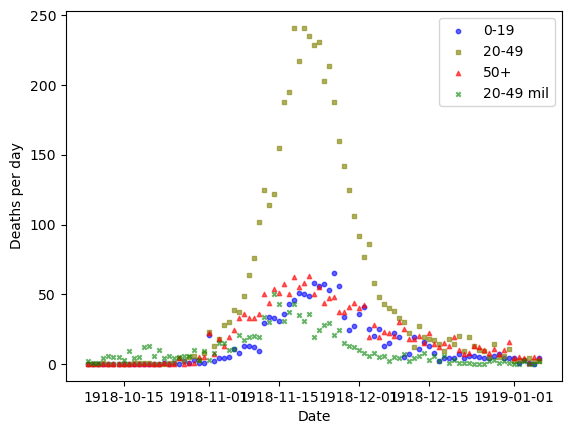

In [7]:
y_young = NZ_death_data.sort_values('date_death')['0-19 military'] + NZ_death_data.sort_values('date_death')['0-19 civilian']
y_mid   = NZ_death_data.sort_values('date_death')['20-49 civilian']
y_old   = NZ_death_data.sort_values('date_death')['50+ military'] + NZ_death_data.sort_values('date_death')['50+ civilian']
y_mil   = NZ_death_data.sort_values('date_death')['20-49 military']

# Cut them all shorter
final_day_index = 91
y_young = y_young[:final_day_index]
y_mid = y_mid[:final_day_index]
y_old = y_old[:final_day_index]
y_mil = y_mil[:final_day_index]
y_data = np.array([y_young, y_mid, y_old, y_mil])

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])[:final_day_index]
dummy = xplot
dummymin = min(xplot)
x_data = dummy.apply(lambda l: l - dummymin).dt.days

plt.scatter(xplot, y_young, color='blue', marker='o', label='0-19', alpha=.6, s=10)
plt.scatter(xplot, y_mid, color='olive', marker='s', label='20-49', alpha=.6, s=10)
plt.scatter(xplot, y_old, color='red', marker='^', label='50+', alpha=.6, s=10)
plt.scatter(xplot, y_mil, color='green', marker='x', label='20-49 mil', alpha=.6, s=10)
plt.xlabel('Date'), plt.ylabel('Deaths per day'), plt.legend()

# Fitting the data

In [8]:
my_optdict = {}

In [86]:
class ModelHandler:
    """Class to communicate between fitting methods defined in SEIRD_fitting, and models defined in SEIRD_model.

    The key purpose of this class is to define how the fitting parameters, 
    held as an arraylike object used by scipy.optimize.minimize in the SEIRD_fitting.DeathFitter class, 
    should modify the seird_model object. For example, which entries in the DeathFitter object will
    correspond to seird_model.gamma, or seird_model.delta. 
    It also contains the method for building the theta_matrix out of the parameters. 
    
    This class should be changed each time dimensions of Y_0 are changed or the number of mixing environments is changed. 
    
    This class should also be changed whenever the choice of which parameters to vary in the fit, and which ones to fix, is changed. 
    """
    def __init__(self,
                 seird_model,
                 date_of_first_infection,
                 dates,
                 Y_0):
        self.seird_model = seird_model
        self.date_of_first_infection = date_of_first_infection
        self.dates = dates
        self.fitting_params = self.get_fitting_params_from_model()
        self.Y_0 = Y_0
        # Keeping the different shape case-falality vs age arrays as a dict
        self.case_fate_vs_age_shape = {'uniform' : np.array([1.,1.,1.,1.]),
                                  'old_bias': np.array([1.,1.,2.5,1.]),
                                  'Frost'   : np.array([1.0166046458777052, 2.54321428859457, 2.291514867225855,2.5848724077879264])}
    
    def print_params(self):
        print("Fitting parameters:\n")
        print("Date of first infection = {}".format(self.date_of_first_infection))
        print("beta_vector             = {}".format(self.seird_model.beta_vector))
        print("latent_period           = {}".format(self.seird_model.latent_period))
        print("gamma                   = {}".format(self.seird_model.gamma))
        print("delta                   = {}".format(self.seird_model.delta))
        print("theta_matrix            =\n{}".format(self.seird_model.theta_matrix))

    def get_derivs_per_day(self):
        """Should rarely be a need to change"""
        return self.seird_model.compute_derivs_per_day(self.dates,
                                                       self.date_of_first_infection,
                                                       self.Y_0)
        
    def get_fitting_params_from_model(self):
        """Sets how fitting parameters are related to the model attributes.

        Should be altered each time a new number of parameters is set, e.g. changing the number of groups or mixing environments. 
        """
        R_value       = np.array(self.seird_model.beta_vector).sum()/len(self.seird_model.beta_vector) / self.seird_model.gamma
        latency        = self.seird_model.latent_period
        case_fatality  = self.seird_model.delta[0] / self.seird_model.gamma
        betheta_matrix = self.seird_model.theta_matrix 
        betheta_vector = np.array([betheta_matrix[0,0],
                betheta_matrix[0,1],
                betheta_matrix[0,2], 
                betheta_matrix[0,3],
                betheta_matrix[1,0],
                betheta_matrix[1,1], 
                betheta_matrix[1,2], 
                betheta_matrix[1,3]])
        
        return [self.date_of_first_infection, 
                R_value, 
                #latency,
                self.seird_model.gamma, 
                case_fatality*100,
                *betheta_vector]
        

    def set_fitting_params_for_model(self, params):
        """Setting how the models parameters change.
        
        Should be altered each time a new number of parameters is changed, or the number of mixing environments, etc.
        """
        p = iter(params)
        self.date_of_first_infection  = next(p)        

        R_vector = next(p) * np.array([5.0, 2.5, 1.0]) #np.array([params[1], params[2], params[3]] )
        #self.seird_model.latent_period= next(p)
        self.seird_model.gamma        = next(p)
        self.seird_model.beta_vector  = R_vector * self.seird_model.gamma
               
        case_fatality = next(p)/100*np.array([1.,1.,10.,1.]) #self.case_fate_vs_age_shape['old_bias']
        # Males only np.array([0.9512240548577646, 2.5848724077879264, 2.005151267917993, 2.5848724077879264])
        # M&F  np.array([1.0166046458777052, 2.54321428859457, 2.291514867225855,2.5848724077879264])
        self.seird_model.delta        = case_fatality * self.seird_model.gamma #*np.array([0.00128991091147788,0.00390851198703093,0.18706393621236134,0.003908511987030937])
        
        theta_matrix_row_0 = np.array([next(p) for i in range(4)])
        theta_matrix_row_1 = np.array([next(p) for i in range(4)])
        self.seird_model.theta_matrix = ModelHandler.build_theta_matrix(*theta_matrix_row_0, *theta_matrix_row_1)

        # def set_fitting_params_for_model(self, params):
        # """Setting how the models parameters change.
        
        # Should be altered each time a new number of parameters is changed, or the number of mixing environments, etc.
        # """
        # self.date_of_first_infection  = params[0]
        # self.seird_model.beta_vector  = [params[1], params[2], params[3]]
        # self.seird_model.gamma        = params[4]
        # self.seird_model.delta        = params[5]*np.array([1.,1.,2.,1.])   #*np.array([0.00128991091147788,0.00390851198703093,0.18706393621236134,0.003908511987030937])
        # self.seird_model.theta_matrix = ModelHandler.build_theta_matrix(params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13])
        
    
    @staticmethod
    def build_theta_matrix(*args) -> npt.NDArray:
        """Builds the theta matrix from a series of arguments. 
    
        Args:
          If first argument is 'Default', the args should be
          the parameters that go into the theta matrix.
          Otherwise args[0], then it should be a function to call and pass the rest of the arguments to. Can be an externally defined function, held as self.theta_matrix_building_method. 
    
        Returns:
          theta_matrix (npt.NDArray): 
            The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
            Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
        """
        theta_matrix = np.array([[   args[0],    args[1], args[2], args[3]],
                                 [   args[4],    args[5], args[6], args[7]],
                                 [1.-args[0]-args[4], 1.-args[1]-args[5], 1.-args[2]-args[6], 1.-args[3]-args[7]]])
        return theta_matrix

In [87]:
Y_day_0_of_infection = np.array([[455502-0, 0, 0, 0, 0],
                                 [481145-46557-0, 0, 0, 0, 0],
                                 [161536-0, 0, 0, 0, 0],
                                 [46557-1, 0, 1, 0, 0]])

gamma_0, delta_0 = 0.91, 0.0080*np.array([1.,1.,10.0,1.])
#np.array([1.0166046458777052, 2.54321428859457, 2.291514867225855,2.5848724077879264])#np.array([1.,1.,1.,1.])
#[0.9512240548577646, 2.5848724077879264, 2.005151267917993]
#np.array([0.00128991091147788,0.00390851198703093,0.18706393621236134,0.003908511987030937])
#np.array([1.,1.,2., 1.])

beta_vector_0 = [3.0,2.0,1.0] #[1.4, 0.8, 0.25]

latent_period = 1.24

theta_y1_0, theta_m1_0, theta_o1_0, theta_mil1_0 = 0.0001, 0.20, 0.0001, 0.34
theta_y2_0, theta_m2_0, theta_o2_0, theta_mil2_0 = 0.083, 0.432, 0.837, 0.55
theta_matrix_0 = ModelHandler.build_theta_matrix( theta_y1_0, 
                                                  theta_m1_0, 
                                                  theta_o1_0, 
                                                  theta_mil1_0, 
                                                  theta_y2_0, 
                                                  theta_m2_0, 
                                                  theta_o2_0, 
                                                  theta_mil2_0)
day_of_first_infection_0 = -0

In [88]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

In [89]:
my_model_handler = ModelHandler(my_model, # SEIRD_model object
                                day_of_first_infection_0, # day of first infection
                                x_data, # list of dates being used
                                Y_day_0_of_infection) # Y_0 

In [90]:
N_theta_params = (theta_matrix_0.shape[0]-1) * theta_matrix_0.shape[1]

lower_bounds = [-35, 0.2, 0.1, 0.1]+[0.0 for i in range(N_theta_params)]+[0.0 for i in range(theta_matrix_0.shape[1])] 
upper_bounds = [ 20, 3.5, 2.4, 5.0]+[1.0 for i in range(N_theta_params)]+[1.0 for i in range(theta_matrix_0.shape[1])] 

bounds = [(lower_bounds[i],upper_bounds[i]) for i in range(len(lower_bounds))] 
N_other_params = len(lower_bounds) - N_theta_params - theta_matrix_0.shape[1]
print('Number of free params = {}, of which {} are for unusual params and {} are for theta params'.format(N_other_params+N_theta_params, N_other_params, N_theta_params))

Number of free params = 12, of which 4 are for unusual params and 8 are for theta params


In [91]:
my_fit = SEIRD_fitting.DeathFitter(x_data,
                                   y_data,
                                   sigma_y=sigma_data,
                                   seird_model=my_model,
                                   bounds=bounds,
                                   model_handler = my_model_handler)
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = 0
beta_vector             = [3.0, 2.0, 1.0]
latent_period           = 1.24
gamma                   = 0.91
delta                   = [0.008 0.008 0.08  0.008]
theta_matrix            =
[[1.000e-04 2.000e-01 1.000e-04 3.400e-01]
 [8.300e-02 4.320e-01 8.370e-01 5.500e-01]
 [9.169e-01 3.680e-01 1.629e-01 1.100e-01]]


### Making constraints object

In [92]:
Param_const = np.identity(N_other_params+N_theta_params)

Theta_summ = [np.zeros((theta_matrix_0.shape[1],N_other_params))]
for i in range(theta_matrix_0.shape[0]-1):
    Theta_summ.append(np.identity(theta_matrix_0.shape[1]))
Theta_const = np.concatenate(Theta_summ, axis=1)

#Theta_const
A = np.concatenate([Param_const,Theta_const], axis=0)

my_fit.constraints = LinearConstraint(A, lb=lower_bounds, ub=upper_bounds)
my_fit.use_constraints = True

print('A, shape {} = \n'.format(A.shape),A)
print('lb, len {} = '.format(len(lower_bounds)),lower_bounds)
print('ub, len {} = '.format(len(upper_bounds)),upper_bounds)

A, shape (16, 12) = 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]]
lb, len 16 =  [-35, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ub, len 16 =  [20, 3.5, 2.4, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Xi value = 136.0020760897302


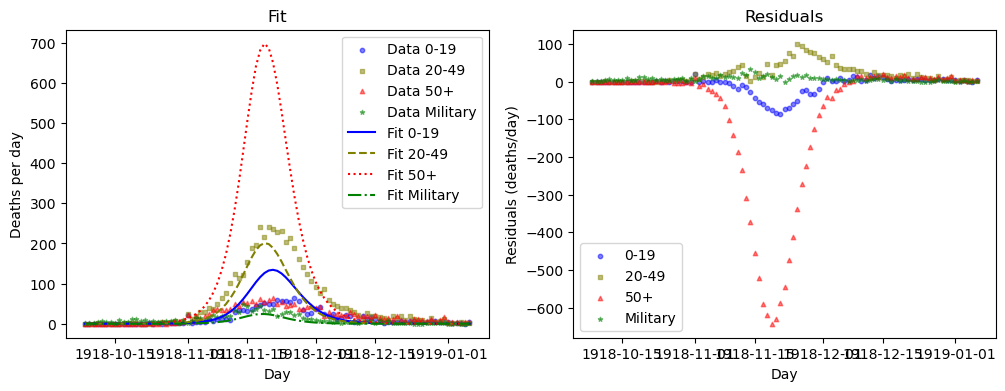

In [93]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot)

In [94]:
%%time
my_fit.do_minimize(method='cobyqa', options={'maxiter':10000, 'catol':1.0e-8} ) #cobyla
my_fit.model_handler.print_params()
my_fit.opt

/home/gavin/Documents/NZ_data/SEIRD_model_files/SEIRD_fitting.py:70: OptimizeWarning: Unknown solver options: catol
  self.opt = minimize(self.__fun_to_minimize,


Fitting parameters:

Date of first infection = -0.0013622449705934293
beta_vector             = [5.06298101 2.53149051 1.0125962 ]
latent_period           = 1.24
gamma                   = 1.9008134973407325
delta                   = [0.04791584 0.04791584 0.47915837 0.04791584]
theta_matrix            =
[[8.38249084e-03 2.75321679e-02 1.99586481e-03 7.80251023e-01]
 [8.73081234e-02 9.72467832e-01 1.85473526e-13 6.36972400e-06]
 [9.04309386e-01 1.25566224e-13 9.98004135e-01 2.19742607e-01]]
CPU times: user 43.1 s, sys: 22.5 ms, total: 43.1 s
Wall time: 39.8 s


 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: 15.278291812930004
       x: [-1.362e-03  5.327e-01  1.901e+00  2.521e+00  8.382e-03
            2.753e-02  1.996e-03  7.803e-01  8.731e-02  9.725e-01
            1.761e-09  6.373e-06]
     nit: 1876
   maxcv: 8.834732279083823e-09
    nfev: 2634

Xi value = 15.42119336241644


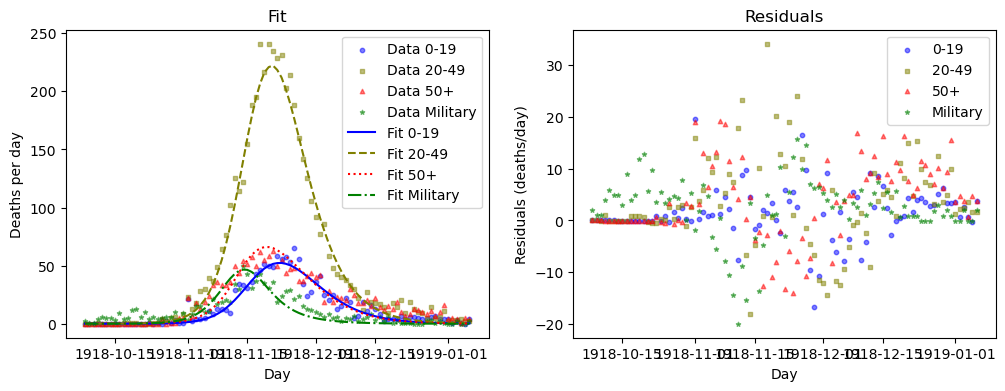

In [84]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot)
#plt.savefig('Deaths_age_and_mil_old_bias.pdf')

Xi value = 15.42119336241644


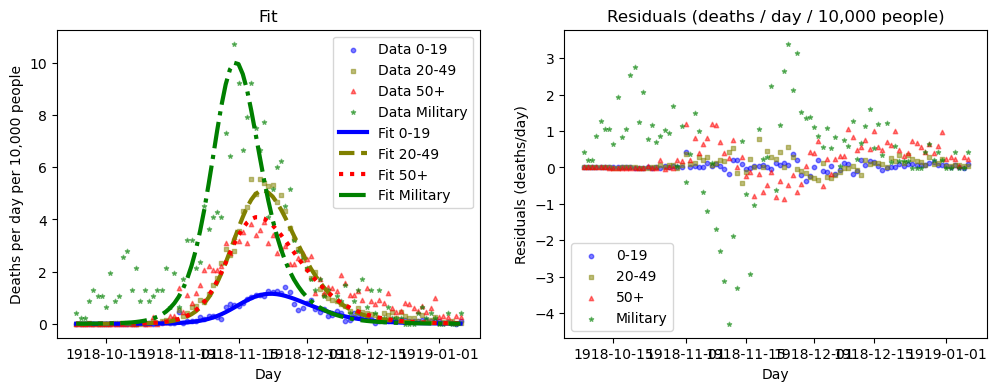

In [85]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot, plot_rate=True)


In [151]:
#my_optdict['First iteration'] = (my_fit.opt, my_fit.model_handler.Y_0)

In [197]:
my_fit.basin_hopping(niter=100, 
                     num_minima_to_save=10, 
                     stepsize=0.11, 
                     T=3.0, 
                     #niter_success=10, 
                     save_direct_to_file=True,
                     save_filename='basin_hopping_Frost_case_fatality_2.txt',
                     minimizer_kwargs = {'method':'cobyla', 
                                         'options':{'maxiter':3000}, 
                                         'tol':1.0e-5, 
                                         'constraints':my_fit.constraints},
                                         #, 'catol':1.0e-8 },
                     disp=True)

basinhopping step 0: f 15.7389
basinhopping step 1: f 15.977 trial_f 15.977 accepted True lowest_f 15.977
found new global minimum on step 1 with function value 15.977
basinhopping step 2: f 15.977 trial_f 15.8454 accepted False lowest_f 15.977
basinhopping step 3: f 15.977 trial_f 15.7606 accepted False lowest_f 15.977
basinhopping step 4: f 15.977 trial_f 17.1517 accepted False lowest_f 15.977
basinhopping step 5: f 15.977 trial_f 15.9835 accepted False lowest_f 15.977
basinhopping step 6: f 15.7888 trial_f 15.7888 accepted True lowest_f 15.7888
found new global minimum on step 6 with function value 15.7888
basinhopping step 7: f 15.7888 trial_f 15.8293 accepted False lowest_f 15.7888
basinhopping step 8: f 15.7888 trial_f 15.8774 accepted False lowest_f 15.7888
basinhopping step 9: f 15.7478 trial_f 15.7478 accepted True lowest_f 15.7478
found new global minimum on step 9 with function value 15.7478
basinhopping step 10: f 15.8279 trial_f 15.8279 accepted True lowest_f 15.7478
basin

In [191]:
my_fit.params_to_model(my_fit.basin_opt.x)

In [196]:
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = -6.461122807219319
beta_vector             = [4.0203287  2.50960454 0.97294923]
latent_period           = 1.9505053213018282
gamma                   = 1.2014067795811378
delta                   = [0.00926429 0.02317624 0.02088251 0.02355586]
theta_matrix            =
[[7.97843795e-03 7.27234431e-02 1.13906925e-01 9.20384008e-01]
 [6.80410777e-02 4.44561376e-01 2.63101676e-01 7.95861479e-02]
 [9.23980484e-01 4.82715181e-01 6.22991399e-01 2.98441807e-05]]


In [95]:
best_uniform_params = my_fit.basin_opt.x

In [60]:
best_params = [-1.46597563e+01,  2.95723835e+00,  1.69042403e+00,  7.94196198e-01,
          1.29831979e+00,  5.87049617e-01,  1.62621945e+00,  2.33190440e+00,
          2.24091322e-02, -2.06014617e-19,  1.08511489e-01,  8.54690481e-01,
          0.00000000e+00,  1.00000000e+00,  2.51302059e-07,  1.45252516e-01]

In [ ]:
#with open('my_basin_minima_29_sept.txt', 'w') as f:
#    for line in my_fit.basin_local_minima:
#        f.write("{}\n".format(line))

Xi value = 15.752534803866206


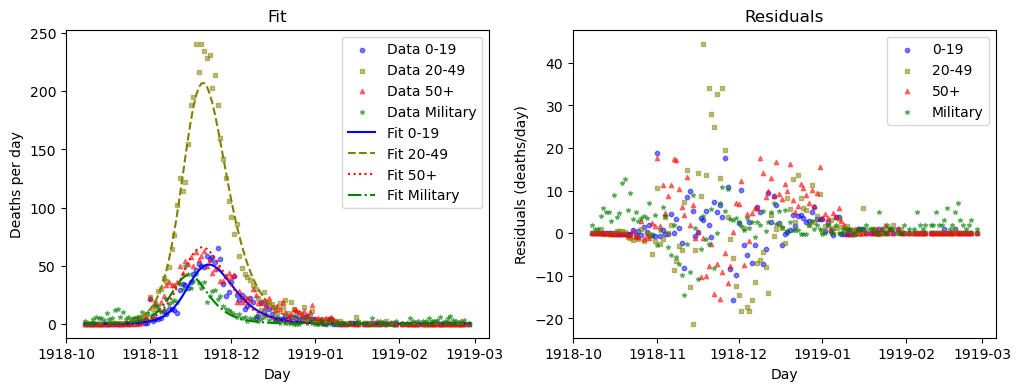

In [192]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot)
#plt.savefig('Deaths_age_and_mil_old_bias.pdf')

Xi value = 15.752534803866206


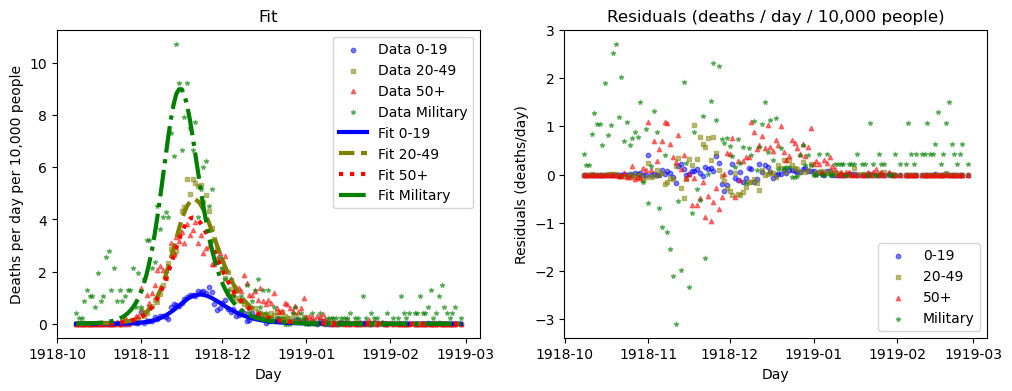

In [193]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot, plot_rate=True)
#plt.savefig('Death_rate_age_and_mil_old_bias.pdf')